In [115]:
# import sys
import os
import gc
import warnings
import random
from copy import deepcopy
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from madgrad import MADGRAD, MirrorMADGRAD
from torch.optim import AdamW
from sklearn.metrics import f1_score
from transformers import (
    get_constant_schedule,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup
)

from sklearn.model_selection import StratifiedKFold,KFold
from tqdm import tqdm

import albumentations as A
warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
PROJECT_DIR = "/content/drive/MyDrive/ml/Контесты/rucode_6/a"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


You should consider upgrading via the 'C:\Users\len\pythonProject1\venv\Scripts\python.exe -m pip install --upgrade pip' command.


# EDA

In [201]:
classes = ['Red', 'Green', 'Violet', 'White', 'Yellow', 'Brown', 'Black', 'Blue', 'Cyan', 'Grey', 'Orange']
counts = []
for class_name in classes:
    counts.append(len(os.listdir(f"./data_ext/train/{class_name}")))

<BarContainer object of 11 artists>

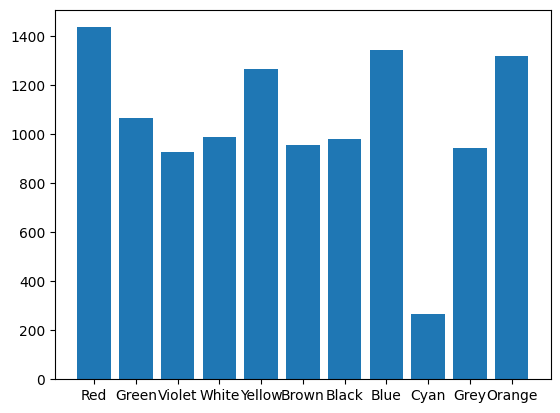

In [202]:
plt.bar(classes, counts)

In [119]:
from PIL import Image

In [142]:
delete_pics = np.array([])

In [151]:
for path in tqdm(os.listdir("data_ext/train/cyan")):
    for path_1 in os.listdir("data_ext/train/cyan"):
        if (path == path_1):
            continue
        im_1 = Image.open(f"data_ext/train/cyan/{path}")
        im_2 = Image.open(f"data_ext/train/cyan/{path_1}")
        im_1 = torchvision.transforms.ToTensor()(im_1)
        im_1 = im_1.to('cuda')
        im_2 = torchvision.transforms.ToTensor()(im_2)
        im_2 = im_2.to('cuda')

        if (torch.equal(im_1, im_2)):
            print(path, path_1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 267/267 [03:12<00:00,  1.39it/s]


# Dataset

In [242]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms=torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.RandomHorizontalFlip(p=0.6),
    torchvision.transforms.RandomVerticalFlip(p=0.6),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=(256,256)),
    torchvision.transforms.Lambda(lambda a: a / 255),
    
#     torchvision.transforms.Normalize(mean, std)
])

In [243]:
train_dataset = torchvision.datasets.ImageFolder(f"./data_ext/train", transform=transforms)

In [244]:
train_dataset.classes

['Black',
 'Blue',
 'Brown',
 'Cyan',
 'Green',
 'Grey',
 'Orange',
 'Red',
 'Violet',
 'White',
 'Yellow']

# Losses

In [189]:
class FocalLoss(nn.Module):
    def __init__(self, weight, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()


class ArcFaceLoss(nn.Module):
    def __init__(self, s=45.0, m=0.1, crit="bce", weight=None, reduction="mean",
                 focal_loss_gamma=0, class_weights_norm="batch"):
        super().__init__()

        self.weight = weight
        self.reduction = reduction
        self.class_weights_norm = class_weights_norm
        
        if crit == "focal":
            self.crit = FocalLoss(gamma=focal_loss_gamma)
        elif crit == "bce":
            self.crit = nn.CrossEntropyLoss(reduction="none")   

        if s is None:
            self.s = torch.nn.Parameter(torch.tensor([45.], requires_grad=True, device='cuda'))
        else:
            self.s = s

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        
    def forward(self, logits, labels):

        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        labels2 = torch.zeros_like(cosine)
        labels2.scatter_(1, labels.view(-1, 1).long(), 1)
        labels2 *= (1 - 0.1)
        labels2 += 0.005
        output = (labels2 * phi) + ((1.0 - labels2) * cosine)

        s = self.s

        output = output * s
        loss = self.crit(output, labels)

        if self.weight is not None:
            w = self.weight[labels].to(logits.device)

            loss = loss * w
            if self.class_weights_norm == "batch":
                loss = loss.sum() / w.sum()
            if self.class_weights_norm == "global":
                loss = loss.mean()
            else:
                loss = loss.mean()
            
            return loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss

# Modules

In [190]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine

# Model

In [191]:
class ResNet(nn.Module):
    def __init__(self, backbone, output_dim):
        super().__init__()
        self.backbone = backbone
        del backbone.fc
        self.backbone.dropout = nn.Dropout(p=0.1)
        self.backbone.fc = torch.nn.Linear(in_features=2048, out_features=output_dim, bias=True)
        
    def forward(self, image):
        out = self.backbone(image)
#         out = self.out(x)
        return out

# Loops

In [247]:
def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device, n_accumulated_grads=0):
    model.to(device)
    model.train()
    total_train_loss = 0

    dl_size = len(data_loader)
    
    preds = []
    targets = []

    batch_i = 0
    steps_to_accumulate_grads = 0
    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()        
        logits = model(image)
        
        preds.append(logits.argmax(dim=1))
        targets.append(target)
                
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        if steps_to_accumulate_grads == n_accumulated_grads:
            optimizer.step()
            scheduler.step()
            steps_to_accumulate_grads = 0
        else:
            steps_to_accumulate_grads += 1
            
    if steps_to_accumulate_grads != 0:
        optimizer.step()
        scheduler.step()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1 = f1_score(preds.cpu(), targets.cpu(), average='macro')
    
    metrics = {
        "Train Loss": total_train_loss / dl_size,
        "Train Accuracy": acc.item(),
        "Train F1": f1.item()
    }
    
    
    return metrics
    
    
def eval_epoch(model, data_loader, loss_function, device):
    model.to(device)
    model.eval()
    total_train_loss = 0
    
    preds = []
    targets = []

    dl_size = len(data_loader)

    
    for batch in tqdm(data_loader):
        image, target = batch
        image = image.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(image)
            preds.append(logits.argmax(dim=1))
            targets.append(target)
        
        loss = loss_function(logits, target)
        total_train_loss += loss.item()
    
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    acc = (targets == preds).sum() / preds.shape[0]
    f1 = f1_score(preds.cpu(), targets.cpu(), average='macro')
    
    metrics = {
        "Eval Loss": total_train_loss / dl_size,
        "Eval Accuracy": acc.item(),
        "Eval F1": f1.item()
    }
    
    return metrics

In [159]:
def cross_validation(project_name,
                     model, 
                     dataset, 
                     loss_function, 
                     strat_array=None,
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle: bool=True, 
                     n_folds: int=4, 
                     epochs: int=5, 
                     lr: float=1e-6,
                     start_fold: int=0, 
                     batch_size: int=32,
                     iters_to_accumulate=None,
                     n_accumulated_grads: int = 0):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    if strat_array:
        kfold = StratifiedKFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset, strat_array)
    else: 
        kfold = KFold(n_folds, shuffle=shuffle, random_state=random_state)
        split = kfold.split(dataset)

    for fold, (train_ids, eval_ids) in enumerate(split):
        if fold >= start_fold:
            print(f'FOLD {fold}')
            print('--------------------------------')
            
            for p in model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)
                else:
                    nn.init.normal_(p)
            
            '''run = wandb.init(
                name=f"fold_{fold}",
                project=f"{project_name}_fold_{fold}",
                config={ 
                         "random_state": random_state, 
                         "shuffle": shuffle,
                         "epochs": epochs, 
                         "learning_rate": lr,
                         "batch_size": batch_size,
                         "iters_to_accumulate": iters_to_accumulate
                        }
            )'''


            optimizer = torch.optim.AdamW(
                model.parameters(),
                lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
            )
            
            train_subsampler = torch.utils.data.Subset(dataset,  train_ids)
            train_loader = torch.utils.data.DataLoader(
                          train_subsampler, 
                          batch_size=batch_size,
                          shuffle=shuffle)

            eval_subsampler = torch.utils.data.Subset(dataset,  eval_ids)
            eval_loader = torch.utils.data.DataLoader(
                          eval_subsampler,
                          batch_size=batch_size,
                          shuffle=shuffle)
            
            total_steps = len(train_loader) * epochs 

            scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

            mrrs = []

            for epoch_i in range(0, epochs):
                train_metrics = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
                eval_metrics = eval_epoch(model, eval_loader, loss_function, device)
                
                print(f"EPOCH: {epoch_i}")
                print(train_metrics)
                print(eval_metrics)
                
                #run.log(train_metrics)
                #run.log(eval_metrics)
                            
            #run.finish()


def single_model(model, 
                     dataset, 
                     loss_function, 
                     device=torch.device("cuda"),
                     random_state: int=69, 
                     shuffle=True,
                     epochs: int=15, 
                     lr: float=1e-6,
                     batch_size: int=32,
                     start_epoch=0
                     ):
    random.seed(random_state),
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    
    loss_function.to(device)
    model.to(device)

    optimizer = MADGRAD(
        model.parameters(),
        lr = lr, # args.learning_rate - default is 5e-5, our notebook had 2e-5
    )

    data_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=batch_size,
                    shuffle=shuffle
    )
    
    total_steps = len(data_loader) * epochs 

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    for epoch_i in range(0, epochs):
        if epoch_i >= start_epoch:
            train_metrics = train_epoch(model, data_loader, loss_function, optimizer, scheduler, device)
            print("EPOCH", epoch_i)
            print(train_metrics)
            # eval_epoch(fold_model, eval_loader, loss_function, device)

# Cross Validation

In [160]:
!nvidia-smi

Thu Nov 17 10:53:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.86       Driver Version: 526.86       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8     1W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [203]:
strat_array = []
target_class = 0
for folder in tqdm(os.listdir('data_ext/train')):
    for _ in range(len(os.listdir('data_ext/train'+f'/{folder}'))):
        strat_array.append(target_class)
    print(folder)
    target_class += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 458.54it/s]

Black
Blue
Brown
Cyan
Green
Grey
Orange
Red
Violet
White
Yellow


In [223]:
from sklearn.utils.class_weight import compute_class_weight

In [229]:
n = len(strat_array)
weights = []
classes = np.arange(11)
correct_weights = compute_class_weight(
                                        class_weight = 'balanced',
                                        classes = classes,
                                        y = np.array(strat_array) )

In [230]:
correct_weights

array([1.06586271, 0.77719156, 1.09147905, 3.91215526, 0.97987378,
       1.10651002, 0.79192226, 0.72790624, 1.12558777, 1.05937673,
       0.8263809 ])

In [231]:
#backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
model_weights = torchvision.models.EfficientNet_B5_Weights.IMAGENET1K_V1
backbone = torchvision.models.efficientnet_b5(weights=model_weights)

In [232]:
backbone

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [233]:
backbone.classifier[1] = nn.Linear(in_features = 2048, out_features =11, bias = True) 

In [238]:
loss_function=FocalLoss(weight=torch.tensor(correct_weights).float())

In [38]:
import wandb

ModuleNotFoundError: No module named 'wandb'

In [248]:
import gc
torch.cuda.empty_cache()
gc.collect()

1243

In [249]:
cross_validation(project_name="car_classification",
                     model=backbone, 
                     dataset=train_dataset,
                     strat_array=strat_array,
                     loss_function=loss_function, 
                     device=torch.device("cuda"),
                     random_state=69, 
                     n_folds=4, 
                     epochs=15, 
                     lr=1e-4,
                     start_fold=0, 
                     batch_size=4)

FOLD 0
--------------------------------


  5%|███████▍                                                                                                                                          | 110/2155 [00:40<12:34,  2.71it/s]


KeyboardInterrupt: 

In [25]:
single_model(model, 
            train_dataset, 
            loss_function, 
            device = torch.device("cuda"),
            random_state = 69, 
            shuffle = True,
            epochs = 15, 
            lr = 1e-4,
            batch_size = 16,
)

  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 0
{'Train Loss': 1.3995169491327109, 'Train Accuracy': 0.5291951894760132, 'Train F1': 0.4732713997364044}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 1
{'Train Loss': 0.8792660309299201, 'Train Accuracy': 0.7188321948051453, 'Train F1': 0.6806460618972778}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 2
{'Train Loss': 0.6522751252065185, 'Train Accuracy': 0.7848500609397888, 'Train F1': 0.7551441192626953}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 3
{'Train Loss': 0.5819737453271925, 'Train Accuracy': 0.8150973320007324, 'Train F1': 0.7883576154708862}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 4
{'Train Loss': 0.46763843013474543, 'Train Accuracy': 0.8335086703300476, 'Train F1': 0.812461793422699}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 5
{'Train Loss': 0.3908041924039614, 'Train Accuracy': 0.8671751618385315, 'Train F1': 0.8525526523590088}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 6
{'Train Loss': 0.29676823859580426, 'Train Accuracy': 0.8992635607719421, 'Train F1': 0.884557843208313}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 7
{'Train Loss': 0.23001780551114753, 'Train Accuracy': 0.920042097568512, 'Train F1': 0.9090695381164551}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 8
{'Train Loss': 0.19123404452742562, 'Train Accuracy': 0.932930052280426, 'Train F1': 0.925681471824646}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 9
{'Train Loss': 0.14718540389883916, 'Train Accuracy': 0.9513413906097412, 'Train F1': 0.9433586597442627}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 10
{'Train Loss': 0.08645885247940652, 'Train Accuracy': 0.9668595790863037, 'Train F1': 0.9606703519821167}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 11
{'Train Loss': 0.06542267669702145, 'Train Accuracy': 0.9763282537460327, 'Train F1': 0.9717156291007996}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 12
{'Train Loss': 0.030159605953906234, 'Train Accuracy': 0.9881641268730164, 'Train F1': 0.9865598082542419}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 13
{'Train Loss': 0.022539671033133774, 'Train Accuracy': 0.9915834069252014, 'Train F1': 0.9905572533607483}


  0%|          | 0/238 [00:00<?, ?it/s]

EPOCH 14
{'Train Loss': 0.018279817016623345, 'Train Accuracy': 0.9944766163825989, 'Train F1': 0.9935630559921265}


In [30]:
def predict(model, device, root=f"./data/public_test/", transform=transforms):
    model.eval()
    model.to(device)
    
    preds = []
    
    img_files = sorted(os.listdir(root), key=lambda x: int(x.split(".")[0]))
    print(img_files)
    for img_file in tqdm(img_files):
        img_bgr = cv2.imread(root + img_file)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        image = transform(img_rgb).to(device)
        
        with torch.no_grad():
            pred = model(image.unsqueeze(dim=0)).argmax(dim=1).cpu().item()
            preds.append(pred)
            
    return pd.Series(preds)

In [31]:
preds = predict(model, device=torch.device("cuda"), root=f"./data/public_test/", transform=transforms)

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg'

  0%|          | 0/1436 [00:00<?, ?it/s]

In [32]:
preds = preds.apply(lambda x: train_dataset.classes[x])

In [34]:
preds.to_csv("baseline_submission.csv", index=False)